In [1]:
# Analiza ERP Posner — funkcje w src.erp
import os

# Szukaj katalogu repozytorium (gdzie jest src/erp) i ustaw go jako cwd
_cwd = os.getcwd()
_repo = _cwd
for _ in range(5):
    if os.path.isdir(os.path.join(_repo, "src", "erp")):
        break
    _parent = os.path.dirname(_repo)
    if _parent == _repo:
        break
    _repo = _parent
if os.path.isdir(os.path.join(_repo, "src", "erp")):
    os.chdir(_repo)

from src.erp import (
    load_smr_block,
    shift_events_42ms,
    block_to_raw,
    build_events,
    uv_to_v_if_needed,
    drop_channel,
    run_artifact_rejection,
    compute_evokeds,
    plot_all_erp,
    find_peaks_simple,
    find_peaks_validated,
    save_peak_tables,
    asymmetry_analysis,
    full_amplitude_stats,
    WRONG_ANS,
)

# Ścieżka do pliku .smr (w repo lub w znanym miejscu)
SMR_FILE = os.path.join(_repo, "data", "grupa6_posner.smr")

# Katalog na wyniki: tabele CSV i wykresy PNG (tworzony automatycznie)
RESULTS_DIR = "results"


In [2]:
# Wczytanie Spike2 i przesunięcie zdarzeń o 42 ms
block = load_smr_block(SMR_FILE, verbose=True)
shift_events_42ms(block)
seg = block.segments[0]

Dostępne sygnały:

Segment 0:
  Kanał 0: Signal stream 0, częstotliwość: 400.00000000000006 Hz, długość: (547904, 19)
  Zdarzenia 0: LewoLewo, liczba: 147
  Zdarzenia 1: LewoPraw, liczba: 63
  Zdarzenia 2: PrawPraw, liczba: 147
  Zdarzenia 3: PrawLew, liczba: 63
  Zdarzenia 4: Keyboard, liczba: 0


In [3]:
# Konwersja bloku Neo -> MNE Raw
raw, eeg_data, sfreq = block_to_raw(block, verbose=True)

Kształt danych: (547904, 19)
Dane: (19, 547904)
Częstotliwość: 400.00000000000006 Hz
Kanały: ['Fp1', 'F3', 'F7', 'C3', 'T3', 'P3', 'T5', 'O1', 'Fz', 'Cz', 'Pz', 'Fp2', 'F4', 'F8', 'C4', 'T4', 'P4', 'T6', 'O2']
Creating RawArray with float64 data, n_channels=19, n_times=547904
    Range : 0 ... 547903 =      0.000 ...  1369.757 secs
Ready.
<Info | 7 non-empty values
 bads: []
 ch_names: Fp1, F3, F7, C3, T3, P3, T5, O1, Fz, Cz, Pz, Fp2, F4, F8, C4, ...
 chs: 19 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 200.0 Hz
 meas_date: unspecified
 nchan: 19
 projs: []
 sfreq: 400.0 Hz
>


In [4]:
# Zdarzenia MNE
events, event_dict = build_events(seg, sfreq, verbose=True)

LewoLewo: 147 zdarzeń, kod 0
LewoPraw: 63 zdarzeń, kod 1
PrawPraw: 147 zdarzeń, kod 2
PrawLew: 63 zdarzeń, kod 3
Keyboard: 0 zdarzeń, kod 0

Łącznie zdarzeń: 420


In [5]:
# Konwersja µV -> V (jeśli potrzeba)
raw = uv_to_v_if_needed(raw, verbose=True)

Dane w µV, konwertuję na V...
Creating RawArray with float64 data, n_channels=19, n_times=547904
    Range : 0 ... 547903 =      0.000 ...  1369.757 secs
Ready.


In [6]:
# Usunięcie kanału F8
raw = drop_channel(raw, ch_names_to_drop=("F8",), verbose=True)

Kanały po usunięciu ('F8',): ['Fp1', 'F3', 'F7', 'C3', 'T3', 'P3', 'T5', 'O1', 'Fz', 'Cz', 'Pz', 'Fp2', 'F4', 'C4', 'T4', 'P4', 'T6', 'O2']



=== Statystyka peak-to-peak (BEZ F8) ===
Kanałów w analizie: 18
Mediana:         32.8 µV
90. percentyl:   43.9 µV
95. percentyl:   49.1 µV
99. percentyl:   84.9 µV


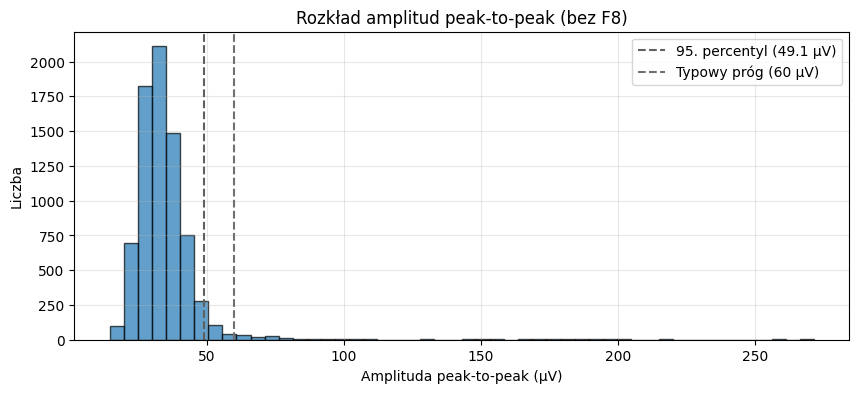


Próg odrzucania (tylko dla ['Fp1', 'Fp2', 'F7']): 60.0 µV
  Okno: 0–600 ms
Epok do odrzucenia (artefakty oczne): 15


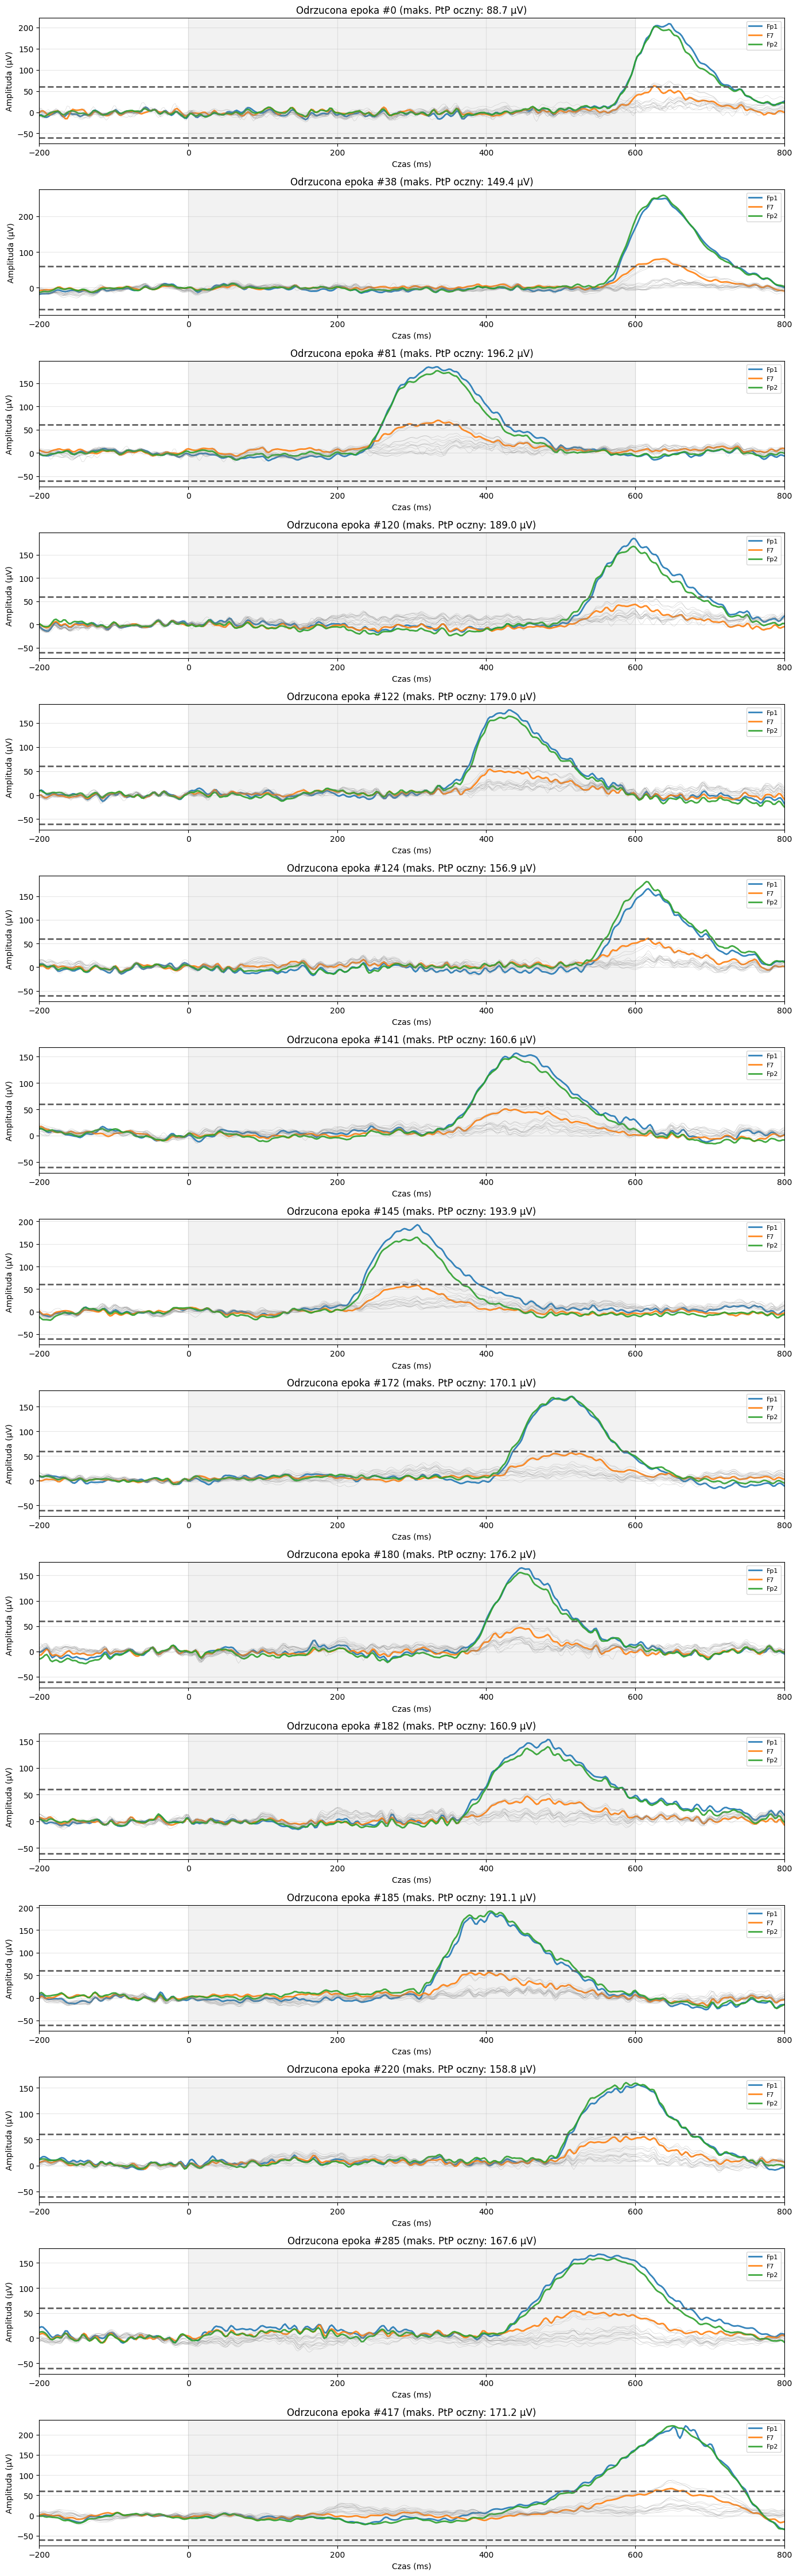

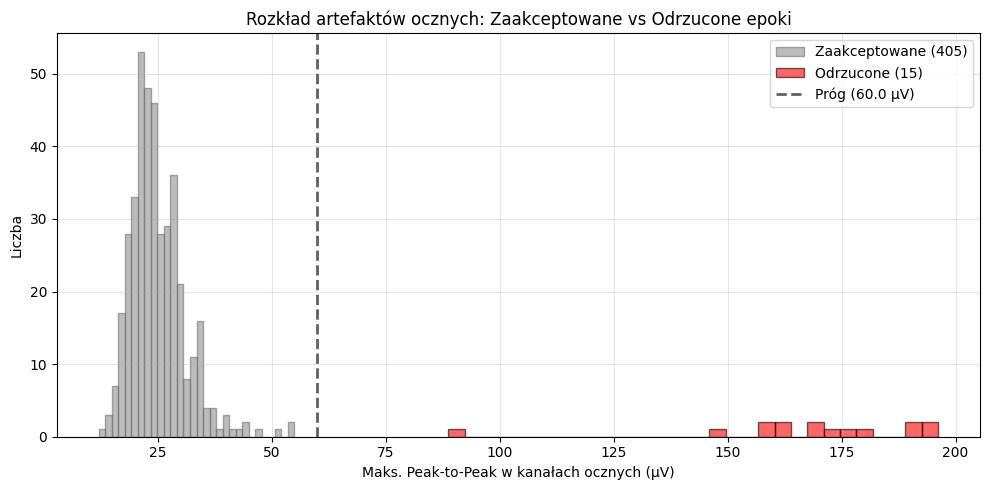


Odrzucanie: 15 artefakty oczne + 8 błędne odpowiedzi = 22 epok łącznie
Dropped 22 epochs: 0, 38, 81, 95, 120, 122, 124, 141, 145, 153, 172, 173, 174, 180, 182, 185, 186, 220, 285, 339, 405, 417

KOŃCOWA STATYSTYKA EPOK
<Epochs | 398 events (all good), -0.2 – 0.8 s (baseline -0.1 – 0 s), ~21.9 MiB, data loaded,
 'left_valid': 141
 'right_invalid': 60
 'right_valid': 139
 'left_invalid': 58>

Wszystkich epok: 420
Zaakceptowane:   398 (94.8%)
Odrzucone:       22
  left_valid: 141 prób
  left_invalid: 58 prób
  right_valid: 139 prób
  right_invalid: 60 prób


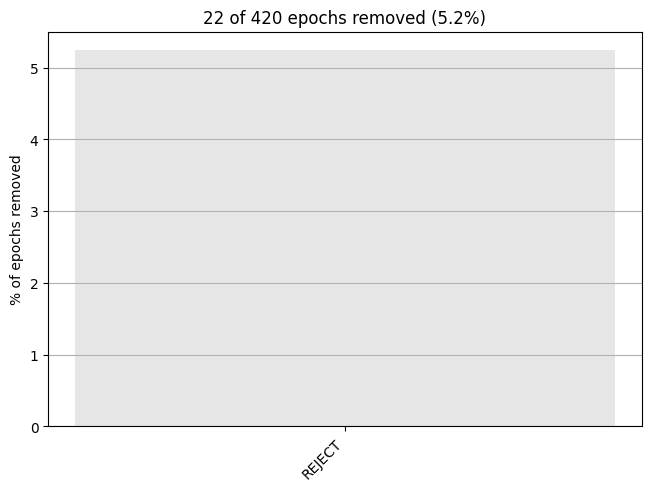


=== Przyczyny odrzucenia epok ===
  REJECT      :  22 razy (5.2% epok)

Kanały w finalnych epokach (18): ['Fp1', 'F3', 'F7', 'C3', 'T3', 'P3', 'T5', 'O1', 'Fz', 'Cz', 'Pz', 'Fp2', 'F4', 'C4', 'T4', 'P4', 'T6', 'O2']


In [7]:
# Odrzucanie artefaktów ocznych + epoki z błędnymi odpowiedziami -> epochs_clean
epochs_clean, epochs_temp = run_artifact_rejection(
    raw, events, event_dict, wrong_ans=WRONG_ANS,
    plot_rejected=True, show_drop_log=True,
)


✓ ERP utworzone (epoki po odrzuceniu artefaktów)
  left_valid: 141 epok
  left_invalid: 58 epok
  right_valid: 139 epok
  right_invalid: 60 epok
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy functi

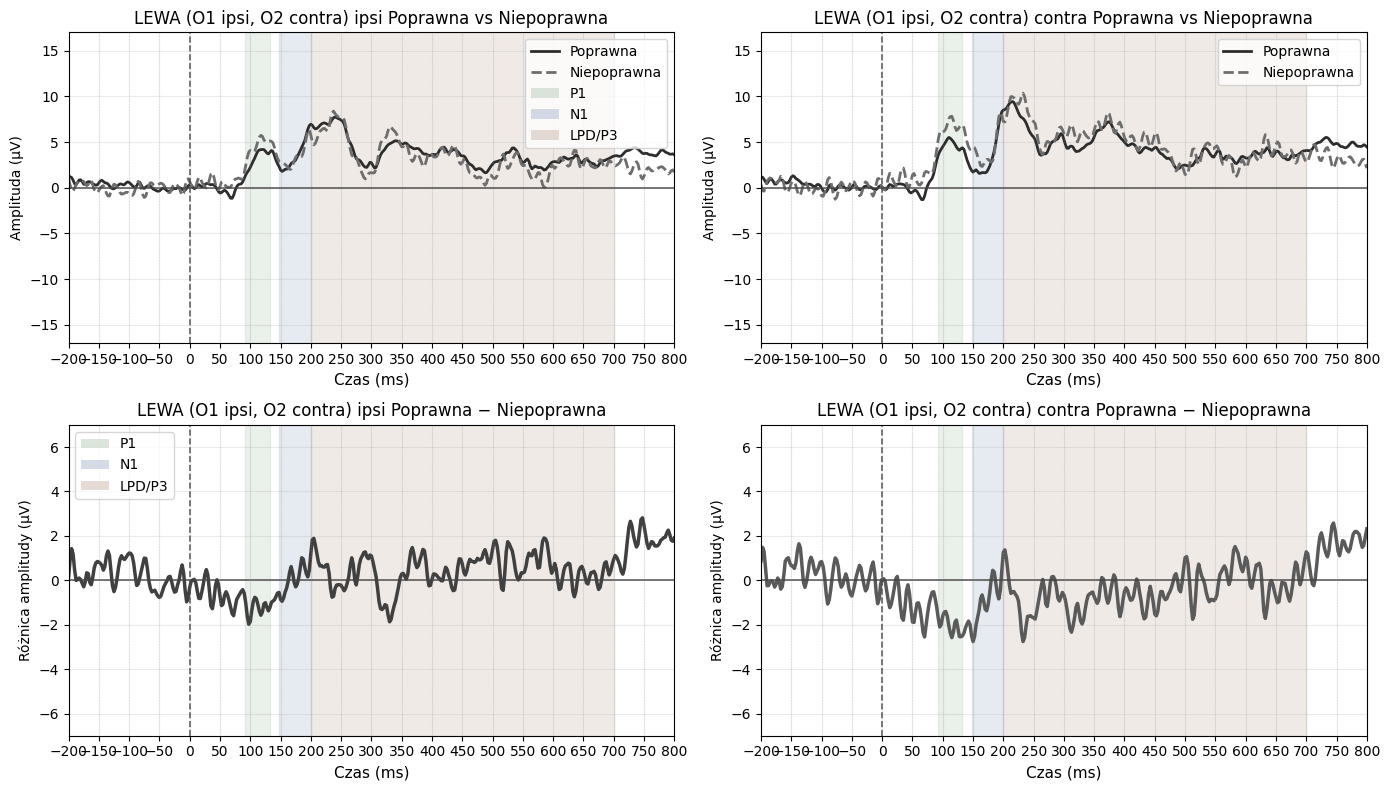

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


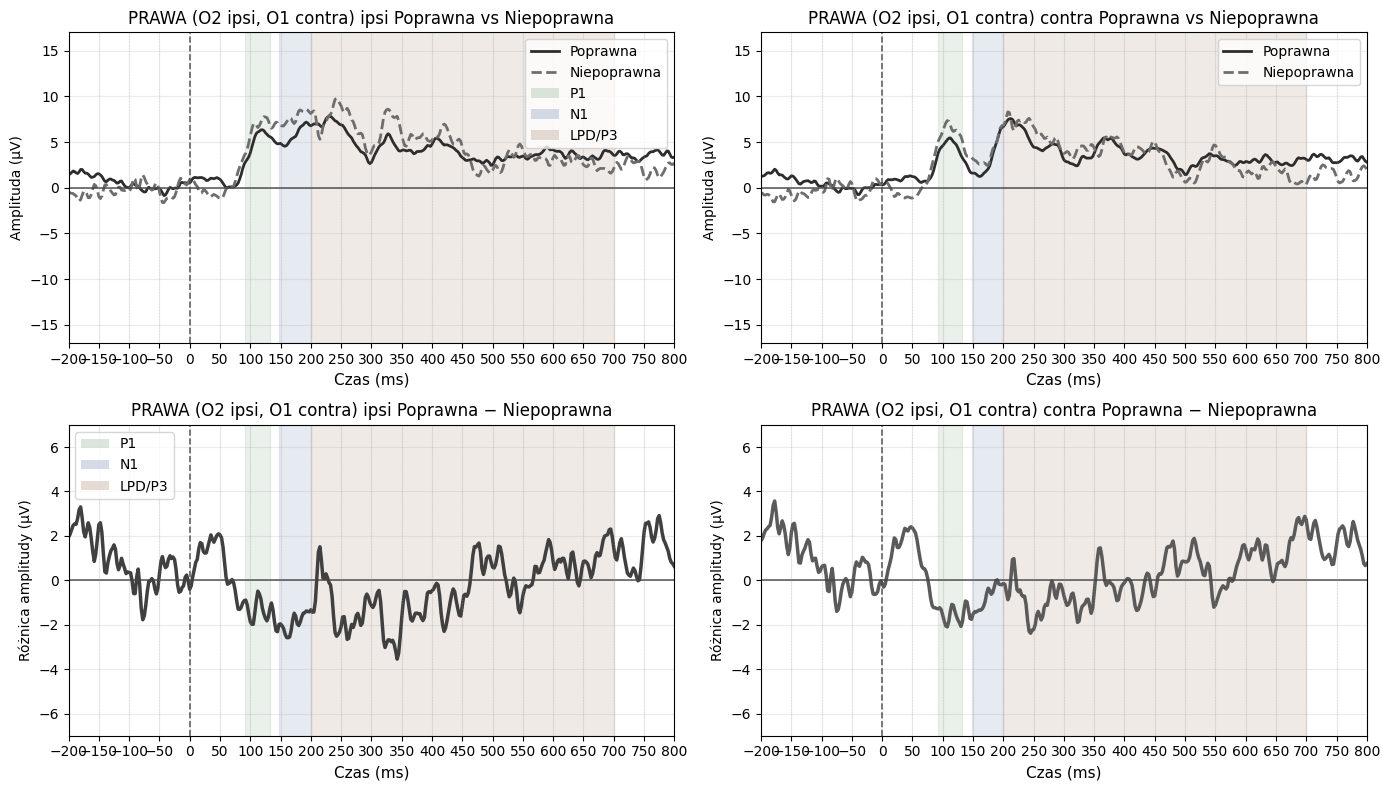

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


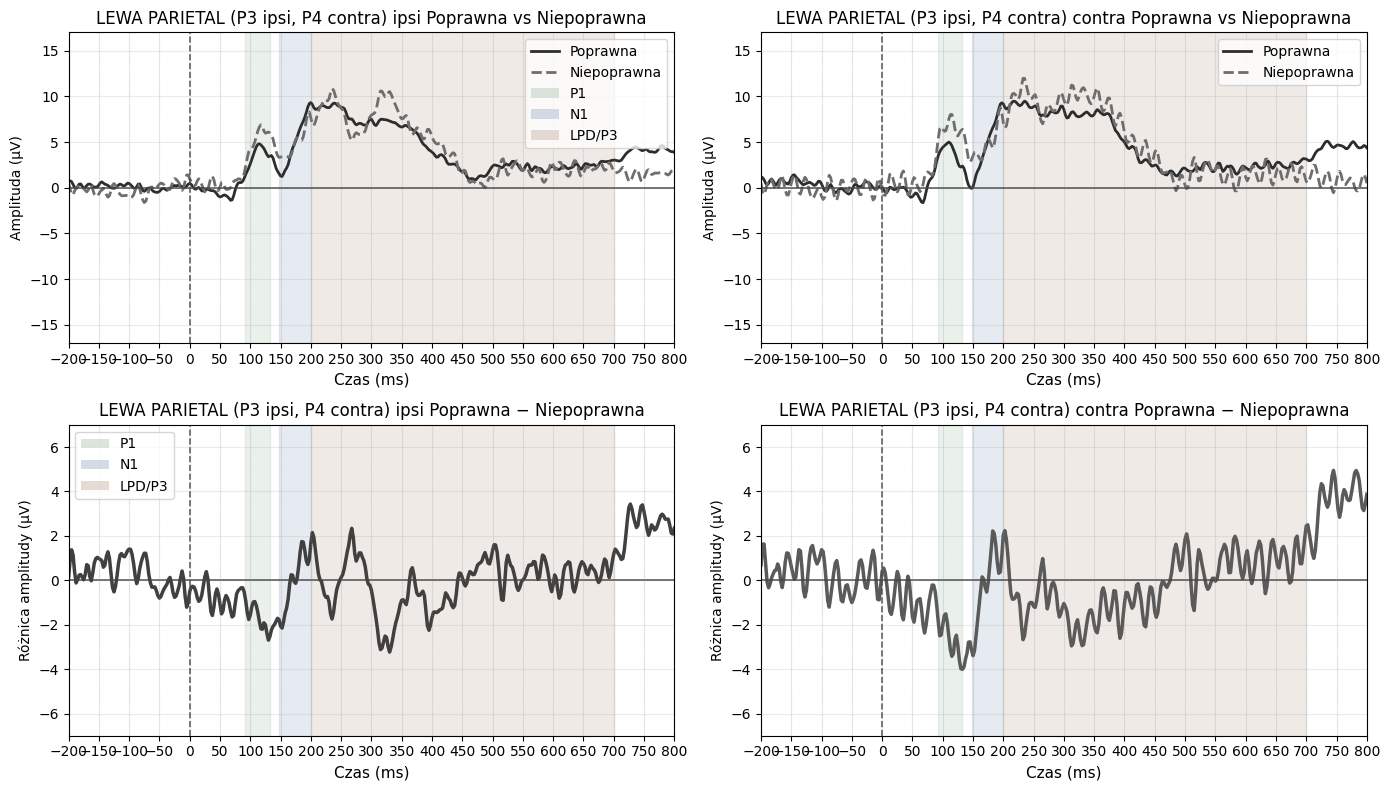

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


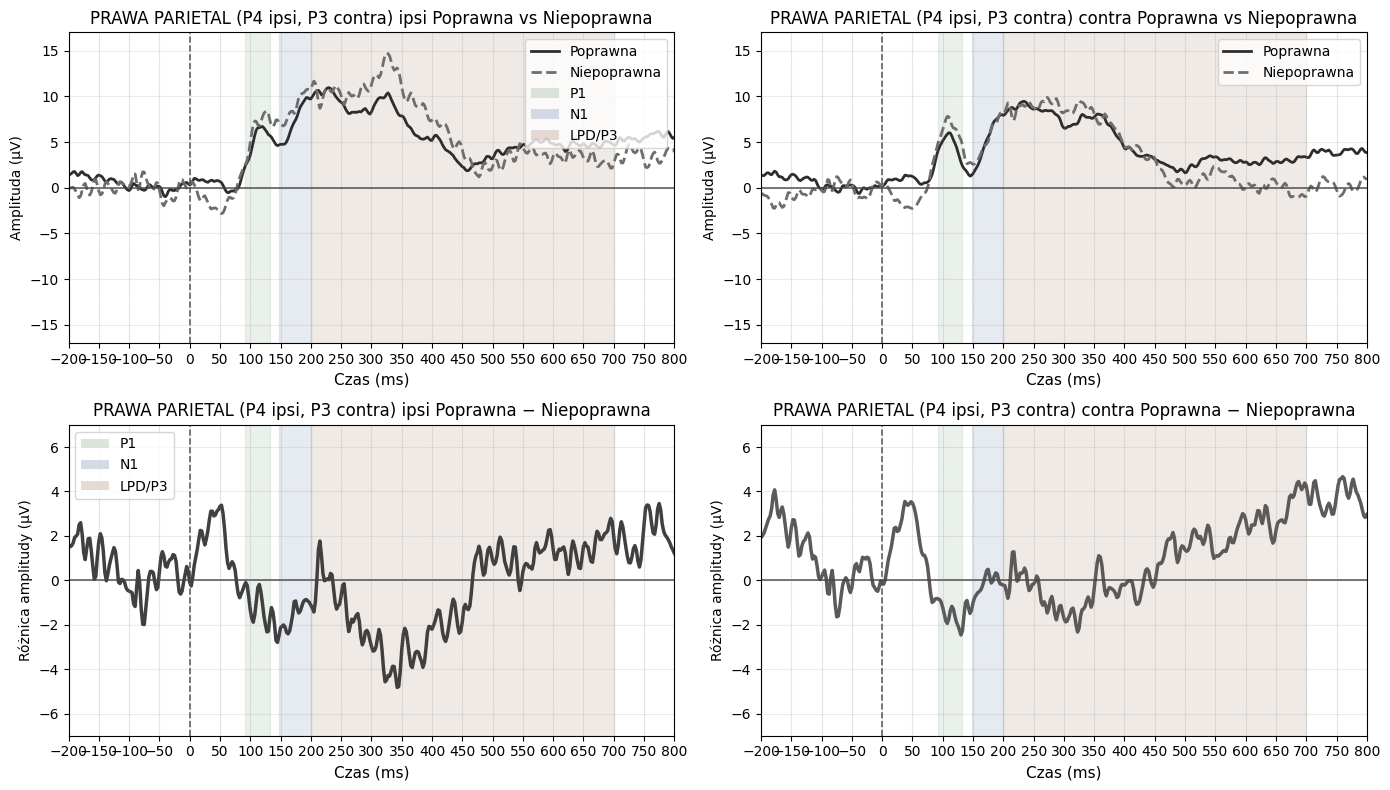

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


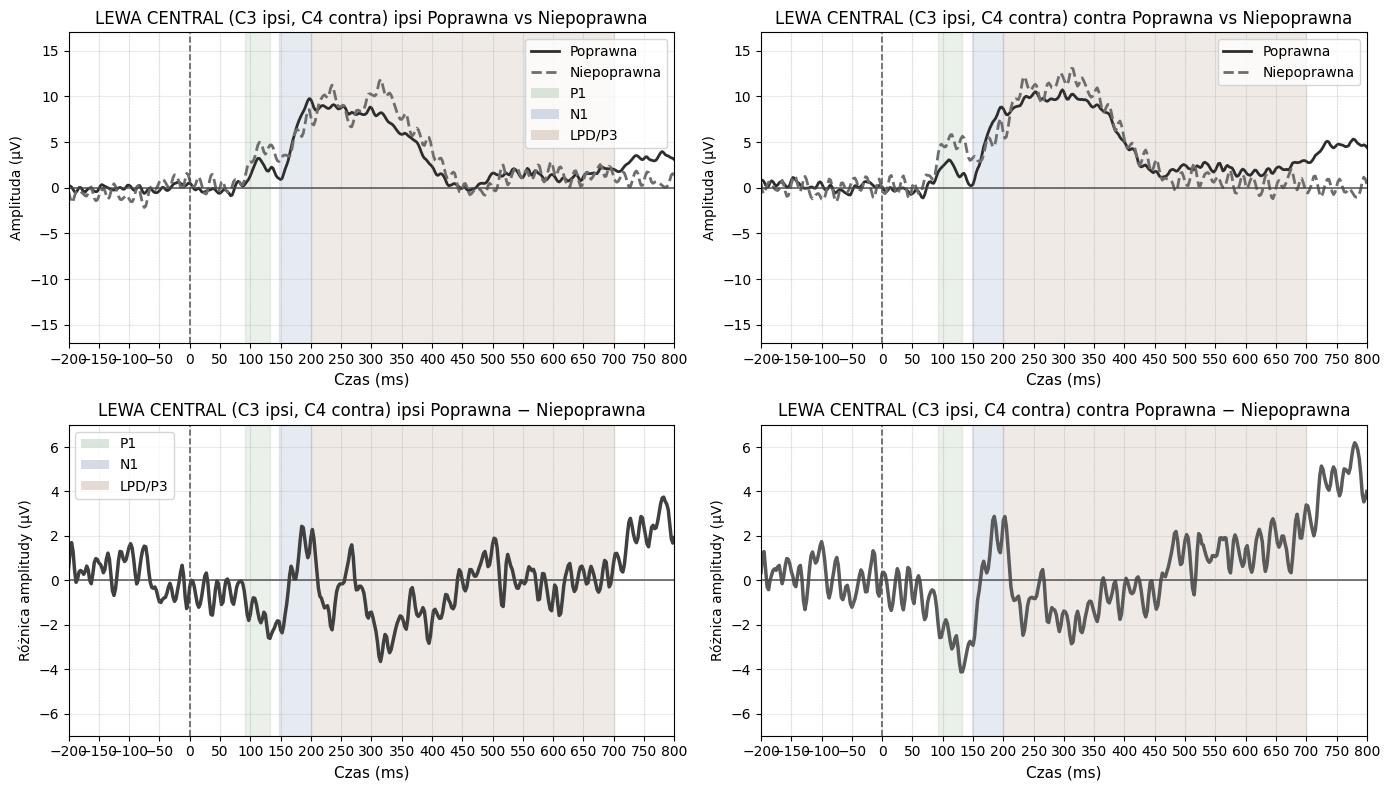

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


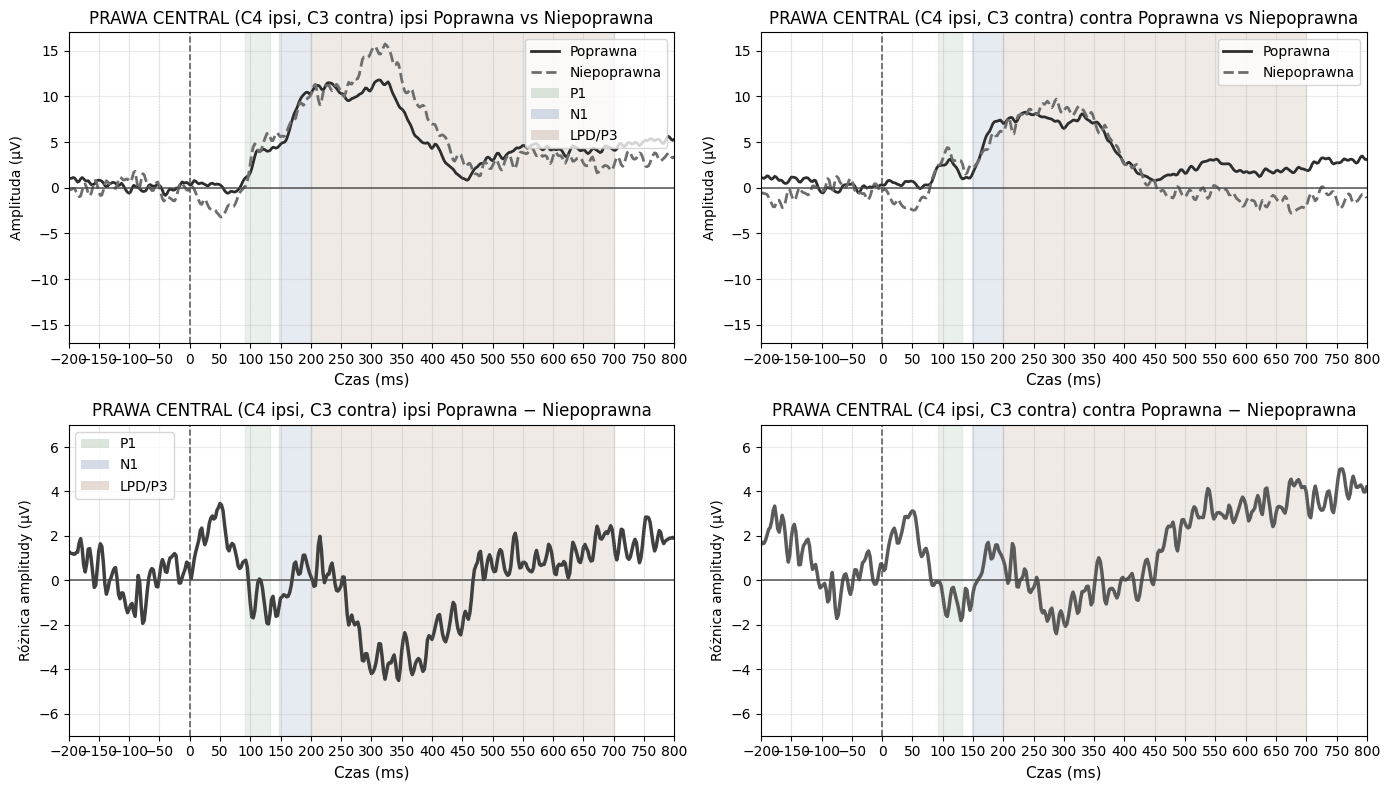

In [8]:
# Obliczenie ERP (evoked) i wykresy ipsi/contra (O1,O2; P3,P4; C3,C4) → zapis w results/
evoked_dict = compute_evokeds(epochs_clean, verbose=True)
plot_all_erp(evoked_dict, save_prefix="ERP", output_dir=RESULTS_DIR)

In [9]:
# Wykrywanie pików (proste + z weryfikacją) i zapis tabel → results/
df_peaks_simple = find_peaks_simple(evoked_dict, verbose=True)
df_peaks_validated = find_peaks_validated(evoked_dict, verbose=True)
save_peak_tables(df_peaks_simple, df_peaks_validated, output_dir=RESULTS_DIR)


TABELA: Amplitudy i latencje składowych ERP
          Warunek Kanał  N70_Amp_uV  N70_Lat_ms  P1_Amp_uV  P1_Lat_ms  N1_Amp_uV  N1_Lat_ms  P3_Amp_uV  P3_Lat_ms
    Lewo Poprawne    O1       -1.16        70.0       4.19      120.0       1.79      152.5       7.74      240.0
    Lewo Poprawne    O2       -1.30        67.5       5.51      110.0       1.57      160.0       9.43      215.0
    Lewo Poprawne    P3       -1.37        67.5       4.81      115.0       1.24      152.5       9.25      240.0
    Lewo Poprawne    P4       -1.63        67.5       5.00      110.0      -0.07      147.5       9.48      217.5
    Lewo Poprawne    C3       -0.86        67.5       3.22      112.5       0.90      150.0       9.26      202.5
    Lewo Poprawne    C4       -1.12        67.5       3.06      110.0       0.24      147.5      10.72      297.5
 Lewo Niepoprawne    O1        0.05        65.0       5.73      117.5       2.01      165.0       8.38      237.5
 Lewo Niepoprawne    O2        0.29        

In [10]:
# Analiza asymetrii lewa vs prawa
asymmetry_analysis(df_peaks_validated, verbose=True)


ANALIZA ASYMETRII: LEWA vs PRAWA STRONA

ŚREDNIE AMPLITUDY LEWA:
  P1: Poprawne=4.30, Niepoprawne=6.54, Różnica=+2.25 µV
  N1: Poprawne=0.95, Niepoprawne=2.70, Różnica=+1.76 µV
  P3: Poprawne=9.38, Niepoprawne=11.08, Różnica=+1.70 µV

ŚREDNIE AMPLITUDY PRAWA:
  P1: Poprawne=5.31, Niepoprawne=6.96, Różnica=+1.64 µV
  N1: Poprawne=2.84, Niepoprawne=4.26, Różnica=+1.43 µV
  P3: Poprawne=9.30, Niepoprawne=11.24, Różnica=+1.94 µV


(             Warunek Kanał  N70_Amp_uV  N70_Lat_ms  P1_Amp_uV  P1_Lat_ms  \
 0      Lewo Poprawne    O1       -1.16        70.0       4.19      120.0   
 1      Lewo Poprawne    O2       -1.30        67.5       5.51      110.0   
 2      Lewo Poprawne    P3       -1.37        67.5       4.81      115.0   
 3      Lewo Poprawne    P4       -1.63        67.5       5.00      110.0   
 4      Lewo Poprawne    C3       -0.86        67.5       3.22      112.5   
 5      Lewo Poprawne    C4       -1.12        67.5       3.06      110.0   
 6   Lewo Niepoprawne    O1        0.05        65.0       5.73      117.5   
 7   Lewo Niepoprawne    O2        0.29        62.5       7.82      115.0   
 8   Lewo Niepoprawne    P3       -0.18        62.5       6.88      117.5   
 9   Lewo Niepoprawne    P4       -0.43        62.5       8.03      115.0   
 10  Lewo Niepoprawne    C3       -0.46        62.5       4.98      115.0   
 11  Lewo Niepoprawne    C4       -0.62        62.5       5.83      115.0   

In [11]:
# Pełna analiza statystyczna amplitud
full_amplitude_stats(df_peaks_validated, verbose=True)


PEŁNA ANALIZA STATYSTYCZNA AMPLITUD ERP
Komponent           Warunek  Średnia   SD   Min   Max  n
       P1     Lewo Poprawne     4.30 0.99  3.06  5.51  6
       P1  Lewo Niepoprawne     6.54 1.23  4.98  8.03  6
       P1    Prawo Poprawne     5.31 1.38  3.13  6.70  6
       P1 Prawo Niepoprawne     6.96 1.49  4.41  8.41  6
       N1     Lewo Poprawne     0.95 0.74 -0.07  1.79  6
       N1  Lewo Niepoprawne     2.70 0.46  2.01  3.32  6
       N1    Prawo Poprawne     2.84 1.82  1.01  4.61  6
       N1 Prawo Niepoprawne     4.26 2.37  1.49  6.77  6
       P3     Lewo Poprawne     9.38 0.96  7.74 10.72  6
       P3  Lewo Niepoprawne    11.08 1.63  8.38 13.07  6
       P3    Prawo Poprawne     9.30 1.75  7.56 11.80  6
       P3 Prawo Niepoprawne    11.24 3.22  7.60 15.73  6


,Komponent,Warunek,Średnia,SD,Min,Max,n
0,P1,Lewo Poprawne,4.298333,0.993004,3.06,5.51,6
1,P1,Lewo Niepoprawne,6.545000,1.230264,4.98,8.03,6
2,P1,Prawo Poprawne,5.311667,1.378600,3.13,6.70,6
3,P1,Prawo Niepoprawne,6.955000,1.489695,4.41,8.41,6
4,N1,Lewo Poprawne,0.945000,0.737692,-0.07,1.79,6
5,N1,Lewo Niepoprawne,2.701667,0.464388,2.01,3.32,6
6,N1,Prawo Poprawne,2.835000,1.821283,1.01,4.61,6
7,N1,Prawo Niepoprawne,4.265000,2.372507,1.49,6.77,6
8,P3,Lewo Poprawne,9.380000,0.958436,7.74,10.72,6
9,P3,Lewo Niepoprawne,11.076667,1.627632,8.38,13.07,6
